In [1]:
from __future__ import print_function,division 
from pykalman import KalmanFilter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import poly1d

from collections import defaultdict
import itertools

#from brmbs.simulation.DataGenerator import generateSimulatedBDTPrice, callableBond, TestFunctionGenerator
from brmbs.model.OrthogonalRegression import *
import brmbs.data.DataLoader as dl
from brmbs.preprocessing.IssuanceProcessor import RegressionPeriod, get_coupon_periods
from brmbs.simulation.PolynomialSimulation import simulate_poly_fit

%matplotlib inline

/Users/Xinhui/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Read Data

In [3]:
df, TBAs, params, all_coupons, rate_Base_raw, FN_issue, rate_Base = dl.load_all_data(data_folder = 'data/')
collapse_without_order, collapse_with_order = get_coupon_periods(df, all_coupons, FN_issue)

data = TBAs[4.5]['2010-01-01':]
prices = data.price.values
rates = data.MTGFNCL.values / 100

ret = (prices[1:] - prices[:-1]) / prices[:-1]
delta_r = rates[1:] - rates[:-1]

full_dates = data.index
ret_dates = data.index[1:]

# Two methods of calculation duration

### Method 1:

$$\frac{\Delta price}{price} = - duration_t * \Delta rate$$

### Method 2:

$$price = \alpha_t + \beta_t * rate$$

or

$$price = \alpha_t + \beta_t * rate + \gamma_t * rate^2$$

then

$$duration = -\frac{price(rate + \Delta r) - price(rate - \Delta r)}{2\Delta r * price}$$

# Kalman Filter Function Definition

In [154]:
def beta_from_kalman_filter(state_cov, obs_cov, trans_cov, ini_mean, y, X):
    dim = len(ini_mean)
    kf_r = KalmanFilter(n_dim_obs = 1, n_dim_state = dim,
              initial_state_mean = ini_mean,
              initial_state_covariance = state_cov,

              transition_matrices = np.eye(dim),
              observation_matrices = X,

              observation_covariance = obs_cov,
              transition_covariance = trans_cov)
    
    kf_r = kf_r.em(y)
    state_means_beta, _ = kf_r.filter(y)
    
    return state_means_beta

In [323]:
def calc_duration_poly(beta, prices, dim, rates):
    if dim==3:
        beta_der = np.vstack((2*beta[:, 0], beta[:, 1])).T
        x = np.expand_dims(np.vstack((rates, np.ones(len(prices)))).T, axis=1).squeeze()
        d = -np.sum(x*beta_der,  axis = 1) / (prices)
    if dim==2:
        beta_der = np.vstack((2*beta[:, 0], beta[:, 1])).T
        x = np.expand_dims(np.vstack((rates, np.ones(len(prices)))).T, axis=1).squeeze()
        d = beta[:,0] / (prices)
    return d

In [245]:
def kf_duration_by_poly_fit_test(test_list, ini_mean, Prices, Rates, Total_T, window):

    '''
    Run regression between price and rate, take derivative. duration = - derivative / price
    
    test_list = [(state_cov, obs_cov, trans_cov), ...]
    '''
    
    dur= {}
    dur_smooth = {}
    dim = len(ini_mean)
    
    #Prepare Observation matrix     
    rates_window = Rates[window:Total_T + window]

    obs_mat_raw = []
    for i in range(dim):
        obs_mat_raw.append(rates_window**(dim-i-1))
    obs_mat_r = np.expand_dims(np.vstack(obs_mat_raw).T, axis=1)
    
    #Getting duration from the Kalman Filter Model
    for test_case in test_list:
        print('runing for case : ', test_case)
        state_cov, obs_cov, trans_cov = test_case
        mean_beta = beta_from_kalman_filter(np.eye(dim) * state_cov,\
                                            obs_cov,\
                                            np.eye(dim) * trans_cov,\
                                            ini_mean,\
                                            Prices[window:Total_T + window], \
                                            obs_mat_r)
        
        duration = calc_duration_poly(mean_beta, Prices[:Total_T], dim, rates_window)
        dur[test_case] = duration        
    return dur

In [246]:
def kf_duration_by_definition_test(test_list, ini_mean, ret, delta_r, Total_T, window, isIntercept):

    '''
    Run regression between return and change in rate. duration is the coefficient
    
    test_list = [(state_cov, obs_cov, trans_cov), ...]
    '''
    
    dur= {}
    dim = len(ini_mean)
    
    delta_r_window = delta_r[window:Total_T + window]
    
    if(isIntercept):
        obs_mat_r = np.expand_dims(np.vstack((delta_r_window, np.ones(Total_T))).T, axis=1)
    else:
        obs_mat_r = np.expand_dims(np.vstack(delta_r_window).T, axis=1)
#    obs_mat_r = np.expand_dims(np.vstack((delta_r_window, np.ones(Total_T))).T, axis=1)
    
    
    #Getting duration from the Kalman Filter Model
    for test_case in test_list:
        print('runing for case : ', test_case)
        state_cov, obs_cov, trans_cov = test_case 
        mean_beta = beta_from_kalman_filter(np.eye(dim) * state_cov,\
                                            obs_cov,\
                                            np.eye(dim) * trans_cov,\
                                            ini_mean,\
                                            ret[window:Total_T + window], \
                                            obs_mat_r)
        
        duration = -mean_beta[:,0]
        dur[test_case] = duration
        
    return dur

# Not Finished
# Q: Kalman Filter with intercept??
## Kalman Filter for (a): $\frac{\Delta price}{price} = - duration_t * \Delta rate$ 


In [334]:
window_20 = 20
D_20_woInt = []
for t in range(len(delta_r) - window_20):
    y = ret[t : t+window_20]
    x = delta_r[t : t+window_20]
    model = sm.OLS(y, x)
    result = model.fit()
    D_20_wInt.append(- result.params[-1])


In [243]:
window_120 = 120
D_120_woInt = []
for t in range(len(delta_r) - window_120):
    y = ret[t : t+window_120]
    x = delta_r[t : t+window_120]
    model = sm.OLS(y, x)
    result = model.fit()
    D_120_wInt.append(- result.params[-1])

In [335]:
ini_mean = [D_120[0]]
state_cov = np.array([1, 0.1, 10])
obs_cov = np.array([0.5, 1, 2])
trans_cov = np.array([1, 5, 10])

all_test_cases = list(itertools.product(state_cov, obs_cov, trans_cov))

Total_T = 1000
dur = kf_duration_by_definition_test(all_test_cases, ini_mean, ret, delta_r, Total_T, window_120, True)

runing for case :  (1.0, 0.5, 1)


ValueError: The shape of all parameters is not consistent.  Please re-check their values.

KeyError: (1.0, 0.5, 5)

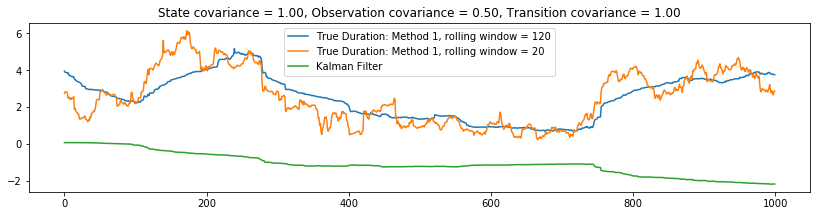

In [336]:
fig = plt.figure(figsize=(14,100))
size = len(all_test_cases)
for i, test_case in enumerate(all_test_cases, 1):
    single_dur = dur[test_case]
    ax = fig.add_subplot(size, 1, i)
    ax.plot(D_120[:Total_T], label = 'True Duration: Method 1, rolling window = 120')
    ax.plot(D_20[window_120 - window_20:Total_T + window_120 - window_20], label = 'True Duration: Method 1, rolling window = 20')
    ax.plot(single_dur, label = 'Kalman Filter')
    ax.legend()
    ax.set_title('State covariance = {:.2f}, Observation covariance = {:.2f}, Transition covariance = {:.2f}'.format(test_case[0], test_case[1], test_case[2]))

## Kalman Filter for (b): $$\frac{\Delta price}{price} = - duration_t * \Delta rate + c$$

In [311]:
window_20 = 20
D_20_wInt = []
for t in range(len(delta_r) - window_20):
    y = ret[t : t+window_20]
    x = delta_r[t : t+window_20]
    x = sm.add_constant(x)
    model = sm.OLS(y, x)
    result = model.fit()
    D_20_wInt.append(- result.params[-1])

In [234]:
window_120 = 120
D_120_wInt = []
for t in range(len(delta_r) - window_120):
    y = ret[t : t+window_120]
    x = delta_r[t : t+window_120]
    x = sm.add_constant(x)
    model = sm.OLS(y, x)
    result = model.fit()
    D_120_wInt.append(- result.params[-1])

In [218]:
ini_mean = [D_120[0], 0]
state_cov = np.array([1, 0.1, 10])
obs_cov = np.array([0.5, 1, 2])
trans_cov = np.array([1, 5, 10])

all_test_cases = list(itertools.product(state_cov, obs_cov, trans_cov))

Total_T = 1000
dur = kf_duration_by_definition_test(all_test_cases, ini_mean, ret, delta_r, Total_T, window_120, True)

runing for case :  (1.0, 0.5, 1)
runing for case :  (1.0, 0.5, 5)
runing for case :  (1.0, 0.5, 10)
runing for case :  (1.0, 1.0, 1)
runing for case :  (1.0, 1.0, 5)
runing for case :  (1.0, 1.0, 10)
runing for case :  (1.0, 2.0, 1)
runing for case :  (1.0, 2.0, 5)
runing for case :  (1.0, 2.0, 10)
runing for case :  (0.10000000000000001, 0.5, 1)
runing for case :  (0.10000000000000001, 0.5, 5)
runing for case :  (0.10000000000000001, 0.5, 10)
runing for case :  (0.10000000000000001, 1.0, 1)
runing for case :  (0.10000000000000001, 1.0, 5)
runing for case :  (0.10000000000000001, 1.0, 10)
runing for case :  (0.10000000000000001, 2.0, 1)
runing for case :  (0.10000000000000001, 2.0, 5)
runing for case :  (0.10000000000000001, 2.0, 10)
runing for case :  (10.0, 0.5, 1)
runing for case :  (10.0, 0.5, 5)
runing for case :  (10.0, 0.5, 10)
runing for case :  (10.0, 1.0, 1)
runing for case :  (10.0, 1.0, 5)
runing for case :  (10.0, 1.0, 10)
runing for case :  (10.0, 2.0, 1)
runing for case 

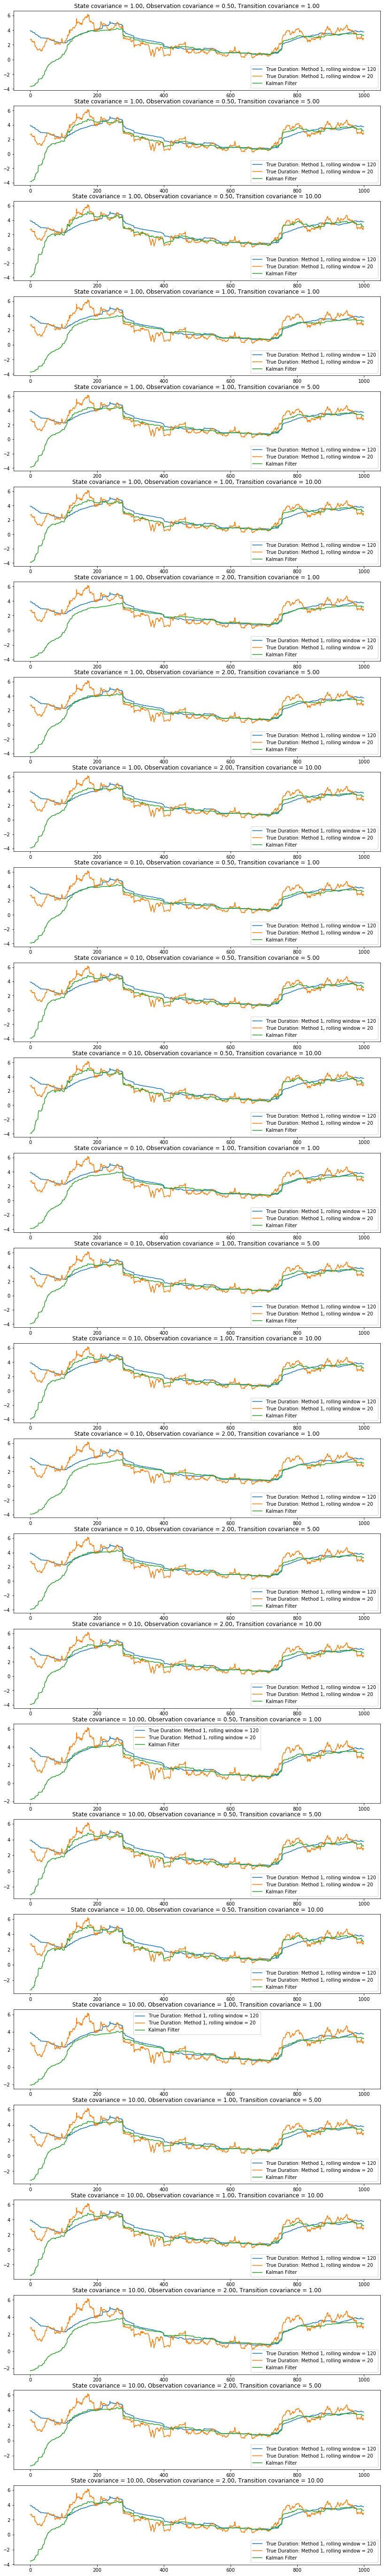

In [235]:
fig = plt.figure(figsize=(14,100))
size = len(all_test_cases)
for i, test_case in enumerate(all_test_cases, 1):
    single_dur = dur[test_case]
    ax = fig.add_subplot(size, 1, i)
    ax.plot(D_120_wInt[:Total_T], label = 'True Duration: Method 1, rolling window = 120')
    ax.plot(D_20_wInt[window_120 - window_20:Total_T + window_120 - window_20], label = 'True Duration: Method 1, rolling window = 20')
    ax.plot(single_dur, label = 'Kalman Filter')
    ax.legend()
    ax.set_title('State covariance = {:.2f}, Observation covariance = {:.2f}, Transition covariance = {:.2f}'.format(test_case[0], test_case[1], test_case[2]))

## Kalman Filter for (c): 
$$price = \alpha_t + \beta_t * rate$$


In [338]:
y = prices[t : t+window_120]
x  = rates[t : t+window_120]
print(sm.OLS(y, np.vstack((np.ones(len(x)),x)).T).fit().params)
print(sm.OLS(y, np.vstack((np.ones(len(x)),x)).T).fit().summary())

[ 113.18599126 -198.69491856]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     61.93
Date:                Fri, 06 Oct 2017   Prob (F-statistic):           1.50e-07
Time:                        05:57:31   Log-Likelihood:                 37.699
No. Observations:                  22   AIC:                            -71.40
Df Residuals:                      20   BIC:                            -69.22
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        113.1860 

In [343]:
D2_20_wInt = []
for t in range(len(rates) - window_20):
    y = prices[t : t+window_20]
    x = rates[t : t+window_20]
    model = sm.OLS(y, np.vstack((np.ones(len(x)),x)).T)
    result = model.fit()
    D2_20_wInt.append(- result.params[-1] / y[-1])

In [344]:
D2_120_wInt = []
for t in range(len(rates) - window_120):
    y = prices[t : t+window_120]
    x = rates[t : t+window_120]
    model = sm.OLS(y, np.vstack((np.ones(len(x)), x)).T)
    result = model.fit()
    D2_120_wInt.append(- result.params[-1] / y[-1])

In [345]:
ini_mean = [D2_120_wInt[0], 0]
#state_cov = np.array([1, 0.1, 10])
#obs_cov = np.array([0.5, 1, 2])
#trans_cov = np.array([1, 5, 10])

state_cov = np.array([1])
obs_cov = np.array([0.5])
trans_cov = np.array([1])



all_test_cases = list(itertools.product(state_cov, obs_cov, trans_cov))

Total_T = 1000
dur = kf_duration_by_poly_fit_test(all_test_cases, ini_mean, prices, rates, Total_T, window_120)

runing for case :  (1, 0.5, 1)


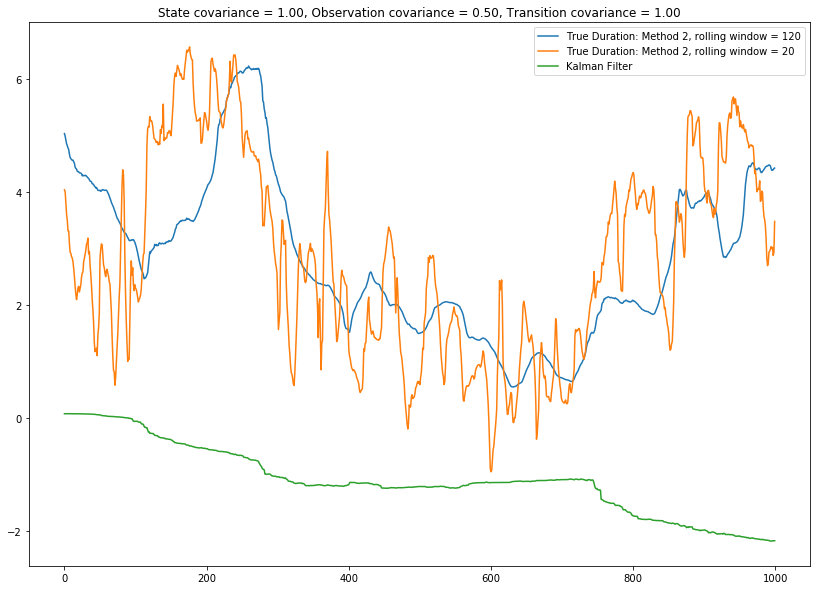

In [346]:
fig = plt.figure(figsize=(14,10))
size = len(all_test_cases)
for i, test_case in enumerate(all_test_cases, 1):
    single_dur = dur[test_case]
    ax = fig.add_subplot(size, 1, i)
    ax.plot(D2_120_wInt[:Total_T], label = 'True Duration: Method 2, rolling window = 120')
    ax.plot(D2_20_wInt[window_120 - window_20:Total_T + window_120 - window_20], label = 'True Duration: Method 2, rolling window = 20')
    ax.plot(single_dur, label = 'Kalman Filter')
    ax.legend()
    ax.set_title('State covariance = {:.2f}, Observation covariance = {:.2f}, Transition covariance = {:.2f}'.format(test_case[0], test_case[1], test_case[2]))

## Kalman Filter for (d): (PCA)
$$price = \alpha_t + \beta_t * rate + \gamma_t * rate^2$$


In [351]:
from sklearn.decomposition import PCA

D3_20_wInt = []
for t in range(len(rates) - window_120):
    y = prices[t : t+window_20]
    x = rates[t : t+window_20]
    x = np.vstack((x**2, x, np.ones(len(x)))).T
    pca = PCA(n_components=2)
    pca.fit(x)
    x = np.matrix(pca.transform(x))
    model = sm.OLS(y, x)
    result = model.fit()
    D3_20_wInt.append(- result.params[-2] / y[-1])

In [352]:
D3_120_wInt = []
for t in range(len(rates) - window_120):
    y = prices[t : t+window_120]
    x = rates[t : t+window_120]
    x = np.vstack((x**2, x, np.ones(len(x)))).T
    pca = PCA(n_components=2)
    pca.fit(x)
    x = np.matrix(pca.transform(x))
    model = sm.OLS(y, x)
    result = model.fit()
    D3_120_wInt.append(- result.params[-2] / y[-1])

In [353]:
ini_mean = [init_a, init_b, 0]
#state_cov = np.array([1, 0.1, 10])
#obs_cov = np.array([0.5, 1, 2])
#trans_cov = np.array([1, 5, 10])

state_cov = np.array([1])
obs_cov = np.array([0.5])
trans_cov = np.array([1])

all_test_cases = list(itertools.product(state_cov, obs_cov, trans_cov))

Total_T = 1500
dur = kf_duration_by_poly_fit_test(all_test_cases, ini_mean, prices, rates, Total_T, window_120)

runing for case :  (1, 0.5, 1)


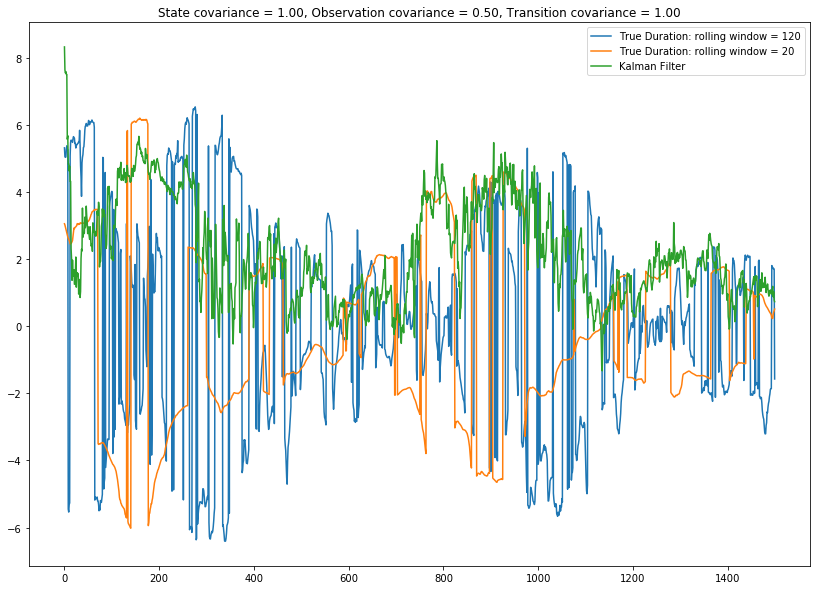

In [354]:
fig = plt.figure(figsize=(14,10))
size = len(all_test_cases)
for i, test_case in enumerate(all_test_cases, 1):
    single_dur = dur[test_case]
    ax = fig.add_subplot(size, 1, i)
    ax.plot(D3_20_wInt[:Total_T], label = 'True Duration: rolling window = 120')
    ax.plot(D3_120_wInt[window_120 - window_20:Total_T + window_120 - window_20], label = 'True Duration: rolling window = 20')
    ax.plot(single_dur, label = 'Kalman Filter')
    ax.legend()
    ax.set_title('State covariance = {:.2f}, Observation covariance = {:.2f}, Transition covariance = {:.2f}'.format(test_case[0], test_case[1], test_case[2]))

## Kalman Filter for (e):

$\frac{\Delta price}{price} = \beta_1* \Delta rate + \beta_2\beta_1 \cdot r\Delta rate$

$Duration = -\frac{\beta_1 + \beta_3 \cdot r}{ P}$

In [415]:
def calc_duration_def(beta, ret, rates, prices, delta_r):
    x = np.expand_dims(np.vstack((np.ones(len(rates)), rates)).T, axis=1).squeeze()
    d = -np.sum(x*beta,  axis = 1)/(delta_r*prices)
    return d

In [416]:
def kf_duration_by_mnyness_test(test_list, ini_mean, prices, ret, Rates, delta_r, Total_T, window, coupon):

    '''
    Run regression between price and rate, take derivative. duration = - derivative / price
    
    test_list = [(state_cov, obs_cov, trans_cov), ...]
    '''
    
    dur= {}
    dur_smooth = {}
    dim = len(ini_mean)
    
    #Prepare Observation matrix     
    delta_r_window = delta_r[window:Total_T + window]
    rates_window = Rates[window:Total_T + window]
    
    obs_mat_r = np.expand_dims(np.vstack((delta_r_window,rates_window*delta_r_window)).T, axis=1)
    
    #Getting duration from the Kalman Filter Model
    for test_case in test_list:
        print('runing for case : ', test_case)
        state_cov, obs_cov, trans_cov = test_case
        mean_beta = beta_from_kalman_filter(np.eye(dim) * state_cov,\
                                            obs_cov,\
                                            np.eye(dim) * trans_cov,\
                                            ini_mean,\
                                            ret[window:Total_T + window], \
                                            obs_mat_r)
        
        duration = calc_duration_def(mean_beta, ret[:Total_T], rates_window, delta_r_window, prices[:Total_T])
        dur[test_case] = duration        
    return dur

In [417]:
init_a, init_b = 0, 0
ini_mean = [init_a, init_b]
#]state_cov = np.array([1, 0.1, 10])
#obs_cov = np.array([0.5, 1, 2])
#trans_cov = np.array([1, 5, 10])

state_cov = np.array([1])
obs_cov = np.array([0.5])
trans_cov = np.array([1])

all_test_cases = list(itertools.product(state_cov, obs_cov, trans_cov))

Total_T = 1500
dur = kf_duration_by_mnyness_test(all_test_cases, ini_mean, prices, ret, rates, delta_r, Total_T, window_120, coupon=0.045)

runing for case :  (1, 0.5, 1)


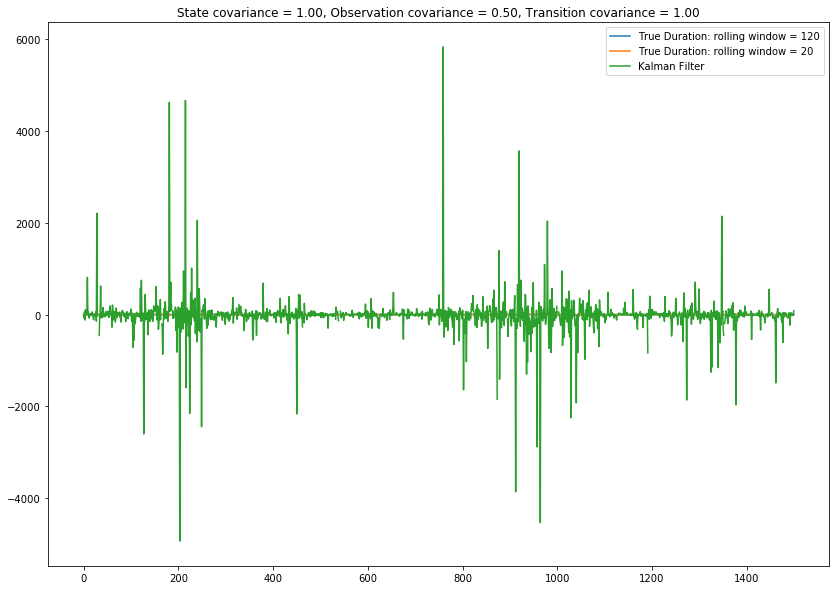

In [418]:
fig = plt.figure(figsize=(14,10))
size = len(all_test_cases)
for i, test_case in enumerate(all_test_cases, 1):
    single_dur = dur[test_case]
    ax = fig.add_subplot(size, 1, i)
    ax.plot(D3_20_wInt[:Total_T], label = 'True Duration: rolling window = 120')
    ax.plot(D3_120_wInt[window_120 - window_20:Total_T + window_120 - window_20], label = 'True Duration: rolling window = 20')
    ax.plot(single_dur, label = 'Kalman Filter')
    ax.legend()
    ax.set_title('State covariance = {:.2f}, Observation covariance = {:.2f}, Transition covariance = {:.2f}'.format(test_case[0], test_case[1], test_case[2]))